# Create Lagged Feature Dataset for Survival Analysis

This notebook creates a proper dataset with lagged features to eliminate data leakage:
- Use **Year T performance** to predict **Year T+1 injury risk**
- Available data: 2020-2023 survival outcomes, 2021-2023 performance stats
- Final dataset: 2021 performance → 2022 injury, 2022 performance → 2023 injury

This eliminates the data leakage where current-year performance was used to predict current-year injuries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Loading datasets...")

Loading datasets...


In [ ]:
# Load the datasets
survival_df = pd.read_csv('../data/processed/')
pitcher_stats = pd.read_csv('../data/processed/pitcher_stats.csv')

print(f"Survival dataset: {survival_df.shape}")
print(f"Pitcher stats: {pitcher_stats.shape}")

print("\nSurvival seasons:", sorted(survival_df['season'].unique()))
print("Performance seasons:", sorted(pitcher_stats['Season'].unique()))

Survival dataset: (1123, 28)
Pitcher stats: (1042, 393)

Survival seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Performance seasons: [np.int64(2021), np.int64(2022), np.int64(2023)]


In [3]:
# Examine the datasets
print("=== SURVIVAL DATASET COLUMNS ===")
print(survival_df.columns.tolist())
print("\n=== PITCHER STATS KEY COLUMNS ===")
perf_cols = ['Name', 'Season', 'Age', 'W', 'L', 'ERA', 'G', 'GS', 'IP', 'H', 'R', 'ER', 
             'HR', 'BB', 'SO', 'WHIP', 'K/9', 'BB/9', 'HR/9', 'FIP', 'WAR']
available_perf_cols = [col for col in perf_cols if col in pitcher_stats.columns]
print(available_perf_cols)

=== SURVIVAL DATASET COLUMNS ===
['player_name', 'season', 'time_to_event', 'event', 'injury_type', 'injury_category', 'age', 'w', 'l', 'era', 'g', 'gs', 'ip', 'h', 'r', 'er', 'hr', 'bb', 'so', 'whip', 'k_per_9', 'bb_per_9', 'hr_per_9', 'fip', 'war', 'high_workload', 'veteran', 'high_era']

=== PITCHER STATS KEY COLUMNS ===
['Name', 'Season', 'Age', 'W', 'L', 'ERA', 'G', 'GS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'WHIP', 'K/9', 'BB/9', 'HR/9', 'FIP', 'WAR']


In [4]:
# Check name matching between datasets
survival_names = set(survival_df['player_name'].str.strip().str.lower())
perf_names = set(pitcher_stats['Name'].str.strip().str.lower())

print(f"Unique names in survival dataset: {len(survival_names)}")
print(f"Unique names in pitcher stats: {len(perf_names)}")
print(f"Names in both datasets: {len(survival_names & perf_names)}")

# Sample of matching names
print("\nSample matching names:")
for name in list(survival_names & perf_names)[:10]:
    print(f"  {name}")

Unique names in survival dataset: 580
Unique names in pitcher stats: 576
Names in both datasets: 576

Sample matching names:
  john means
  zach plesac
  aroldis chapman
  jose hernandez
  hayden wesneski
  scott effross
  a.j. minter
  hirokazu sawamura
  eli morgan
  tanner banks


In [5]:
# Prepare datasets for merging
# Standardize names for matching
survival_df['name_clean'] = survival_df['player_name'].str.strip().str.lower()
pitcher_stats['name_clean'] = pitcher_stats['Name'].str.strip().str.lower()

# Select key performance features
performance_features = {
    'Season': 'season_perf',
    'Name': 'player_name', 
    'Age': 'age_prev',
    'W': 'w_prev',
    'L': 'l_prev', 
    'ERA': 'era_prev',
    'G': 'g_prev',
    'GS': 'gs_prev',
    'IP': 'ip_prev',
    'H': 'h_prev',
    'R': 'r_prev',
    'ER': 'er_prev',
    'HR': 'hr_prev',
    'BB': 'bb_prev', 
    'SO': 'so_prev',
    'WHIP': 'whip_prev',
    'FIP': 'fip_prev',
    'WAR': 'war_prev'
}

# Add calculated features if columns exist
if 'K/9' in pitcher_stats.columns:
    performance_features['K/9'] = 'k_per_9_prev'
if 'BB/9' in pitcher_stats.columns:
    performance_features['BB/9'] = 'bb_per_9_prev'
if 'HR/9' in pitcher_stats.columns:
    performance_features['HR/9'] = 'hr_per_9_prev'

# Extract available performance columns
available_perf_features = {k: v for k, v in performance_features.items() if k in pitcher_stats.columns}
print(f"Available performance features: {len(available_perf_features)}")
print(list(available_perf_features.keys()))

Available performance features: 21
['Season', 'Name', 'Age', 'W', 'L', 'ERA', 'G', 'GS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'SO', 'WHIP', 'FIP', 'WAR', 'K/9', 'BB/9', 'HR/9']


In [6]:
# Create performance dataset
perf_df = pitcher_stats[list(available_perf_features.keys()) + ['name_clean']].copy()
perf_df = perf_df.rename(columns=available_perf_features)
perf_df = perf_df.rename(columns={'season_perf': 'season'})

print(f"Performance dataset shape: {perf_df.shape}")
print("\nPerformance dataset columns:")
print(perf_df.columns.tolist())

Performance dataset shape: (1042, 22)

Performance dataset columns:
['season', 'player_name', 'age_prev', 'w_prev', 'l_prev', 'era_prev', 'g_prev', 'gs_prev', 'ip_prev', 'h_prev', 'r_prev', 'er_prev', 'hr_prev', 'bb_prev', 'so_prev', 'whip_prev', 'fip_prev', 'war_prev', 'k_per_9_prev', 'bb_per_9_prev', 'hr_per_9_prev', 'name_clean']


In [7]:
# Create lagged dataset
# We want: Year T performance → Year T+1 injury
lagged_data = []

for year in [2021, 2022]:  # Performance years
    injury_year = year + 1  # Injury year
    
    print(f"\nCreating lagged features: {year} performance → {injury_year} injury")
    
    # Get performance data for year T
    perf_year = perf_df[perf_df['season'] == year].copy()
    print(f"  Performance data ({year}): {len(perf_year)} players")
    
    # Get injury data for year T+1  
    injury_year_data = survival_df[survival_df['season'] == injury_year].copy()
    print(f"  Injury data ({injury_year}): {len(injury_year_data)} players")
    
    # Merge on player name
    merged = pd.merge(
        injury_year_data[['name_clean', 'season', 'time_to_event', 'event', 
                         'injury_type', 'injury_category', 'age']],
        perf_year.drop(columns=['season']),  # Remove season to avoid confusion
        on='name_clean',
        how='inner'
    )
    
    print(f"  Merged dataset: {len(merged)} players")
    print(f"  Event rate: {merged['event'].mean():.1%}")
    
    lagged_data.append(merged)

# Combine all years
final_lagged_df = pd.concat(lagged_data, ignore_index=True)
print(f"\nFinal lagged dataset: {final_lagged_df.shape}")
print(f"Overall event rate: {final_lagged_df['event'].mean():.1%}")
print(f"Seasons: {sorted(final_lagged_df['season'].unique())}")


Creating lagged features: 2021 performance → 2022 injury
  Performance data (2021): 338 players
  Injury data (2022): 347 players
  Merged dataset: 219 players
  Event rate: 45.2%

Creating lagged features: 2022 performance → 2023 injury
  Performance data (2022): 347 players
  Injury data (2023): 357 players
  Merged dataset: 217 players
  Event rate: 42.9%

Final lagged dataset: (436, 27)
Overall event rate: 44.0%
Seasons: [np.int64(2022), np.int64(2023)]


In [8]:
# Add derived features similar to original dataset
print("Adding derived features...")

# High workload indicator (using previous year's games started)
if 'gs_prev' in final_lagged_df.columns:
    gs_75th = final_lagged_df['gs_prev'].quantile(0.75)
    final_lagged_df['high_workload_prev'] = (final_lagged_df['gs_prev'] >= gs_75th).astype(int)
    print(f"  High workload threshold (GS): {gs_75th}")

# Veteran status (age >= 30)
if 'age_prev' in final_lagged_df.columns:
    final_lagged_df['veteran_prev'] = (final_lagged_df['age_prev'] >= 30).astype(int)
    veteran_pct = final_lagged_df['veteran_prev'].mean()
    print(f"  Veteran percentage: {veteran_pct:.1%}")

# High ERA indicator (poor performance)
if 'era_prev' in final_lagged_df.columns:
    era_75th = final_lagged_df['era_prev'].quantile(0.75)
    final_lagged_df['high_era_prev'] = (final_lagged_df['era_prev'] >= era_75th).astype(int)
    print(f"  High ERA threshold: {era_75th:.2f}")

print(f"\nFinal dataset shape: {final_lagged_df.shape}")

Adding derived features...
  High workload threshold (GS): 27.0
  Veteran percentage: 35.1%
  High ERA threshold: 4.41

Final dataset shape: (436, 30)


In [9]:
# Handle missing data
print("Missing data summary:")
missing_summary = final_lagged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

if len(missing_summary) > 0:
    print("\nImputing missing values...")
    # For numeric columns, use median
    numeric_cols = final_lagged_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if final_lagged_df[col].isnull().any():
            median_val = final_lagged_df[col].median()
            final_lagged_df[col].fillna(median_val, inplace=True)
            print(f"  {col}: filled with median {median_val:.3f}")
    
    # For categorical columns, use mode or 'unknown'
    categorical_cols = final_lagged_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if final_lagged_df[col].isnull().any():
            final_lagged_df[col].fillna('unknown', inplace=True)
            print(f"  {col}: filled with 'unknown'")

print(f"\nMissing data after imputation: {final_lagged_df.isnull().sum().sum()}")

Missing data summary:
injury_type        244
injury_category    244
dtype: int64

Imputing missing values...
  injury_type: filled with 'unknown'
  injury_category: filled with 'unknown'

Missing data after imputation: 0


/tmp/ipykernel_72047/1030065441.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_lagged_df[col].fillna('unknown', inplace=True)


In [10]:
# Summary statistics
print("=== LAGGED DATASET SUMMARY ===")
print(f"Total observations: {len(final_lagged_df)}")
print(f"Injury events: {final_lagged_df['event'].sum()}")
print(f"Event rate: {final_lagged_df['event'].mean():.1%}")
print(f"Seasons: {sorted(final_lagged_df['season'].unique())}")

print("\n=== SEASON BREAKDOWN ===")
season_summary = final_lagged_df.groupby('season').agg({
    'event': ['count', 'sum', 'mean'],
    'time_to_event': ['mean', 'median']
}).round(3)
season_summary.columns = ['Total_Players', 'Injuries', 'Injury_Rate', 'Mean_Time', 'Median_Time']
print(season_summary)

print("\n=== KEY FEATURES AVAILABLE ===")
feature_cols = [col for col in final_lagged_df.columns 
               if col.endswith('_prev') and col not in ['name_clean']]
print(f"Lagged performance features ({len(feature_cols)}):")
for col in feature_cols:
    print(f"  {col}")

=== LAGGED DATASET SUMMARY ===
Total observations: 436
Injury events: 192
Event rate: 44.0%
Seasons: [np.int64(2022), np.int64(2023)]

=== SEASON BREAKDOWN ===
        Total_Players  Injuries  Injury_Rate  Mean_Time  Median_Time
season                                                              
2022              219        99        0.452    132.658        180.0
2023              217        93        0.429    132.581        180.0

=== KEY FEATURES AVAILABLE ===
Lagged performance features (22):
  age_prev
  w_prev
  l_prev
  era_prev
  g_prev
  gs_prev
  ip_prev
  h_prev
  r_prev
  er_prev
  hr_prev
  bb_prev
  so_prev
  whip_prev
  fip_prev
  war_prev
  k_per_9_prev
  bb_per_9_prev
  hr_per_9_prev
  high_workload_prev
  veteran_prev
  high_era_prev


In [11]:
# Data quality checks
print("=== DATA QUALITY CHECKS ===")

# Check for reasonable time_to_event values
print(f"Time to event range: {final_lagged_df['time_to_event'].min()} - {final_lagged_df['time_to_event'].max()} days")
print(f"Mean time to event: {final_lagged_df['time_to_event'].mean():.1f} days")

# Check age distribution
if 'age_prev' in final_lagged_df.columns:
    print(f"\nAge distribution (from previous year):")
    print(f"  Range: {final_lagged_df['age_prev'].min()} - {final_lagged_df['age_prev'].max()}")
    print(f"  Mean: {final_lagged_df['age_prev'].mean():.1f}")

# Check performance metrics make sense
if 'gs_prev' in final_lagged_df.columns:
    print(f"\nGames started (previous year): {final_lagged_df['gs_prev'].min()} - {final_lagged_df['gs_prev'].max()}")

if 'era_prev' in final_lagged_df.columns:
    print(f"ERA (previous year): {final_lagged_df['era_prev'].min():.2f} - {final_lagged_df['era_prev'].max():.2f}")

print("\n=== INJURY TYPE BREAKDOWN ===")
if 'injury_type' in final_lagged_df.columns:
    injury_types = final_lagged_df[final_lagged_df['event']==1]['injury_type'].value_counts()
    print(injury_types.head(10))

=== DATA QUALITY CHECKS ===
Time to event range: 1 - 181 days
Mean time to event: 132.6 days

Age distribution (from previous year):
  Range: 22 - 42
  Mean: 28.5

Games started (previous year): 0 - 33
ERA (previous year): 0.95 - 8.07

=== INJURY TYPE BREAKDOWN ===
injury_type
Undisclosed                14
Strained groin             13
Shoulder inflammation      13
Strained oblique           12
Strained hamstring          8
Strained forearm            6
Elbow inflammation          6
Strained shoulder           5
Lower back inflammation     4
Tommy John surgery          4
Name: count, dtype: int64


In [12]:
# Compare to original (leaked) dataset
print("=== COMPARISON TO ORIGINAL DATASET ===")
print(f"Original dataset size: {len(survival_df)}")
print(f"Lagged dataset size: {len(final_lagged_df)}")
print(f"Size reduction: {(1 - len(final_lagged_df)/len(survival_df)):.1%}")

print(f"\nOriginal event rate: {survival_df['event'].mean():.1%}")
print(f"Lagged event rate: {final_lagged_df['event'].mean():.1%}")

# This reduction is expected because:
# 1. We lost 2020 (no previous year performance)
# 2. We lost 2023 data if we only have performance through 2022
# 3. Not all players appear in consecutive years

=== COMPARISON TO ORIGINAL DATASET ===
Original dataset size: 1123
Lagged dataset size: 436
Size reduction: 61.2%

Original event rate: 42.5%
Lagged event rate: 44.0%


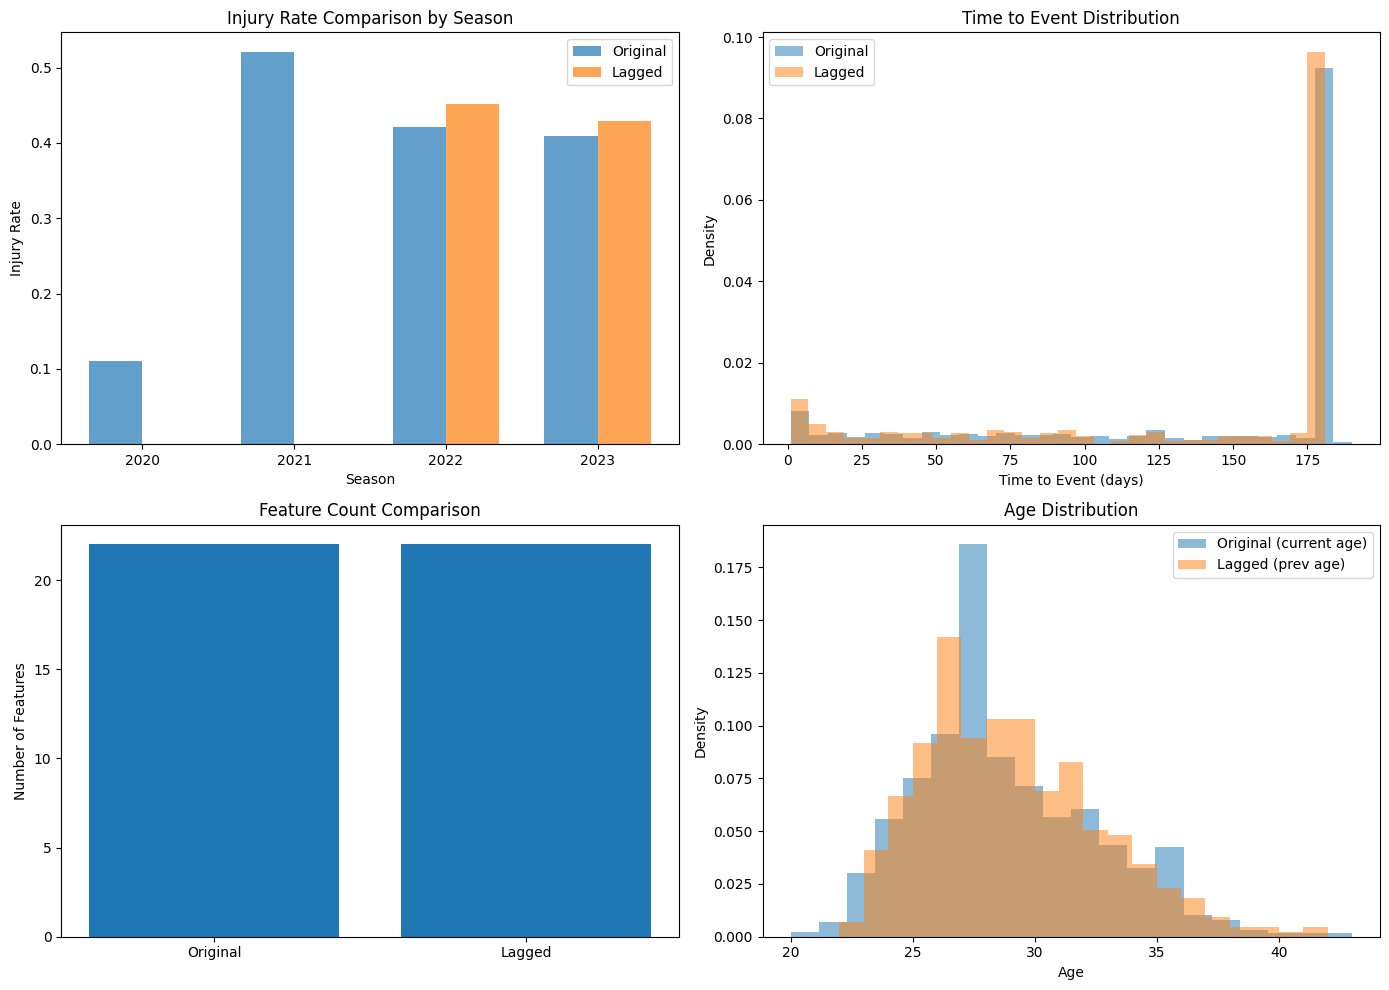

In [13]:
# Visualize the key differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compare event rates by season
orig_season_rates = survival_df.groupby('season')['event'].mean()
lagged_season_rates = final_lagged_df.groupby('season')['event'].mean()

seasons = sorted(set(orig_season_rates.index) | set(lagged_season_rates.index))
orig_rates = [orig_season_rates.get(s, np.nan) for s in seasons]
lagged_rates = [lagged_season_rates.get(s, np.nan) for s in seasons]

x = np.arange(len(seasons))
width = 0.35

axes[0,0].bar(x - width/2, orig_rates, width, label='Original', alpha=0.7)
axes[0,0].bar(x + width/2, lagged_rates, width, label='Lagged', alpha=0.7)
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Injury Rate')
axes[0,0].set_title('Injury Rate Comparison by Season')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(seasons)
axes[0,0].legend()

# Compare time to event distributions
axes[0,1].hist(survival_df['time_to_event'], bins=30, alpha=0.5, label='Original', density=True)
axes[0,1].hist(final_lagged_df['time_to_event'], bins=30, alpha=0.5, label='Lagged', density=True)
axes[0,1].set_xlabel('Time to Event (days)')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Time to Event Distribution')
axes[0,1].legend()

# Show feature availability
orig_features = [col for col in survival_df.columns if col not in 
                ['player_name', 'season', 'time_to_event', 'event', 'injury_type', 'injury_category', 'name_clean']]
lagged_features = [col for col in final_lagged_df.columns if col.endswith('_prev')]

axes[1,0].bar(['Original', 'Lagged'], [len(orig_features), len(lagged_features)])
axes[1,0].set_ylabel('Number of Features')
axes[1,0].set_title('Feature Count Comparison')

# Age distribution comparison (if available)
if 'age' in survival_df.columns and 'age_prev' in final_lagged_df.columns:
    axes[1,1].hist(survival_df['age'].dropna(), bins=20, alpha=0.5, label='Original (current age)', density=True)
    axes[1,1].hist(final_lagged_df['age_prev'].dropna(), bins=20, alpha=0.5, label='Lagged (prev age)', density=True)
    axes[1,1].set_xlabel('Age')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Age Distribution')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

In [14]:
# Save the lagged dataset
output_file = '../data/processed/survival_dataset_lagged.csv'
final_lagged_df.to_csv(output_file, index=False)
print(f"\nLagged dataset saved to: {output_file}")
print(f"Dataset shape: {final_lagged_df.shape}")
print(f"Columns: {final_lagged_df.columns.tolist()}")

# Create a feature mapping for easy reference
feature_mapping = {
    'target': ['time_to_event', 'event'],
    'identifiers': ['name_clean', 'season'],
    'injury_info': ['injury_type', 'injury_category'],
    'lagged_features': [col for col in final_lagged_df.columns if col.endswith('_prev')]
}

print("\n=== FEATURE MAPPING ===")
for category, features in feature_mapping.items():
    available_features = [f for f in features if f in final_lagged_df.columns]
    print(f"{category}: {available_features}")


Lagged dataset saved to: ../data/processed/survival_dataset_lagged.csv
Dataset shape: (436, 30)
Columns: ['name_clean', 'season', 'time_to_event', 'event', 'injury_type', 'injury_category', 'age', 'player_name', 'age_prev', 'w_prev', 'l_prev', 'era_prev', 'g_prev', 'gs_prev', 'ip_prev', 'h_prev', 'r_prev', 'er_prev', 'hr_prev', 'bb_prev', 'so_prev', 'whip_prev', 'fip_prev', 'war_prev', 'k_per_9_prev', 'bb_per_9_prev', 'hr_per_9_prev', 'high_workload_prev', 'veteran_prev', 'high_era_prev']

=== FEATURE MAPPING ===
target: ['time_to_event', 'event']
identifiers: ['name_clean', 'season']
injury_info: ['injury_type', 'injury_category']
lagged_features: ['age_prev', 'w_prev', 'l_prev', 'era_prev', 'g_prev', 'gs_prev', 'ip_prev', 'h_prev', 'r_prev', 'er_prev', 'hr_prev', 'bb_prev', 'so_prev', 'whip_prev', 'fip_prev', 'war_prev', 'k_per_9_prev', 'bb_per_9_prev', 'hr_per_9_prev', 'high_workload_prev', 'veteran_prev', 'high_era_prev']
